#### This script contains a function that will take in a dataframe of a tracked video and generate all of the distance dataframes for the different combos of shrimp


In [1]:
import numpy as np
import pandas as pd
import tracktor as tr
import seaborn as sns
import plotly.express as px
import cv2
import sys
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
from itertools import combinations

#### Access the function below!

In [2]:
zebra_df = pd.read_csv('/Users/lukefields/Desktop/Shrimp-Capstone/tracktor-master/output/zebrafish_video_tracked.csv')
zebra_df

,Unnamed: 0,frame,pos_x,pos_y,id
0,0,3.0,783.514170,62.967611,A
1,1,3.0,174.192848,60.541507,B
2,2,3.0,303.360000,119.509630,C
3,3,3.0,193.814035,293.143860,D
4,4,3.0,226.002179,333.840959,E
...,...,...,...,...,...
74985,74985,15000.0,258.306878,259.282540,A
74986,74986,15000.0,228.713333,218.145333,B
74987,74987,15000.0,355.438155,24.925577,C
74988,74988,15000.0,164.821256,166.346216,D


In [3]:
! ls /Users/lukefields/Desktop/Shrimp-Capstone/test_data_out/

AB_distances.csv AE_distances.csv BE_distances.csv DE_distances.csv
AC_distances.csv BC_distances.csv CD_distances.csv
AD_distances.csv BD_distances.csv CE_distances.csv


In [4]:
from itertools import combinations
output_filepath = "/Users/lukefields/Desktop/Shrimp-Capstone/test_data_out/"
# output_filepath = '/Users/lukefields/Desktop/Shrimp-Capstone/tracktor-master/videos/' + video + '_tracked.csv'
# Output filepath will be something like the template below
# "/Users/yourname/Desktop/shripfolder/where-ever-it-is-you-want-your-output/" + shrimp1 + shrimp2 + "_distances.csv"
# Or a realized version, Luke Fields's specific file path for where he wants the output
# "/Users/lukefields/Desktop/Shrimp-Capstone/tracktor-master/output/zebrafish_video_tracked.csv"

def master_funct_combo(dataframe, output_filepath, fps):
    diff_ids = dataframe["id"].unique()
    shrimp_combo = []
    for combo in combinations(diff_ids, 2):  # 2 for pairs, 3 for triplets, etc
        shrimp_combo.append(combo)
    
    for pair in shrimp_combo:
        shrimpX = pair[0]
        shrimpY = pair[1]

        # This will subset our dataframe into one with just the two animals we care about
        dataframe2 = dataframe[(dataframe["id"] == shrimpX) | (dataframe["id"] == shrimpY)]

        for idx, ID in enumerate(np.unique(dataframe2['id'])):
                dataframe2['id'][dataframe2['id'] == ID] = idx
                #print(dataframe.shape)
        distances = []
        for fr in np.unique(dataframe['frame']):
                tmp = dataframe2[dataframe2['frame'] == fr]
                x = tmp[tmp['id'] == 0]['pos_x'].values[0] - tmp[tmp['id'] == 1]['pos_x'].values[0]
                y = tmp[tmp['id'] == 0]['pos_y'].values[0] - tmp[tmp['id'] == 1]['pos_y'].values[0]
                distances.append(np.sqrt(x**2 + y**2))

        timestamp = np.unique(dataframe2['frame'])/fps

        pair_list = []
        for i in range(len(distances)):
                pair_list.append(pair)

        dist_df = pd.DataFrame([pair_list, timestamp, distances]).transpose()
        dist_df.columns = ["Pair", "Timestamp", "Distance"]

        shrimpX_str = str(shrimpX)
        shrimpY_str = str(shrimpY)

        new_output_filepath = output_filepath + shrimpX_str + shrimpY_str + "_distances.csv"

        dist_df.to_csv(new_output_filepath, sep=',')

In [5]:
test_output = "/Users/lukefields/Desktop/Shrimp-Capstone/test_data_out/"

master_funct_combo(zebra_df, test_output, 60)

/var/folders/n2/x_q5fj895dg04jddh7fb9m000000gn/T/ipykernel_25155/2232424711.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe2['id'][dataframe2['id'] == ID] = idx
/var/folders/n2/x_q5fj895dg04jddh7fb9m000000gn/T/ipykernel_25155/2232424711.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe2['id'][dataframe2['id'] == ID] = idx
/var/folders/n2/x_q5fj895dg04jddh7fb9m000000gn/T/ipykernel_25155/2232424711.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

In [6]:
AB_df = pd.read_csv('/Users/lukefields/Desktop/Shrimp-Capstone/test_data_out/AB_distances.csv')
AB_df = AB_df.drop(["Unnamed: 0"], axis = 1)
AB_df


,Pair,Timestamp,Distance
0,"('A', 'B')",0.050000,609.326152
1,"('A', 'B')",0.066667,615.918418
2,"('A', 'B')",0.083333,624.806074
3,"('A', 'B')",0.100000,631.687560
4,"('A', 'B')",0.116667,638.212907
...,...,...,...
14993,"('A', 'B')",249.933333,46.208769
14994,"('A', 'B')",249.950000,47.162086
14995,"('A', 'B')",249.966667,48.692018
14996,"('A', 'B')",249.983333,49.624659


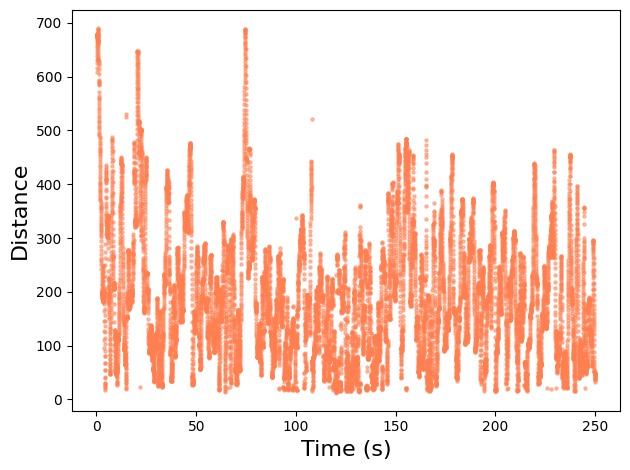

In [7]:
def graph_dist(df_dist):
    plt.scatter(df_dist["Timestamp"], df_dist["Distance"], c='#FF7F50', s=5, alpha=0.5)
    plt.xlabel('Time (s)', fontsize=16)
    plt.ylabel('Distance', fontsize=16)
    plt.tight_layout()
    plt.show()
    
graph_dist(AB_df)

In [11]:
def graph_dist(df_dist):
    dist_plot = px.line(df_dist, x = "Timestamp", y = "Distance")
    dist_plot.update_traces(line_color = "purple")
    dist_plot.show()
    
graph_dist(AB_df)

In [60]:
def important_timestamps(df, dist_cutoff):
    # Create a new column "Previous" that includes the distance between two shrimp in the previous frame
    df["Previous"] = df["Distance"].shift(1)
    
    # Define evaluation statements for our function to see whether shrimp are exiting or entering "importance"
    enter_eval = "Distance <= " + str(dist_cutoff) + " and not (Previous <= " + str(dist_cutoff) + ")"
    exit_eval = "Previous <= " + str(dist_cutoff) + " and not (Distance <= " + str(dist_cutoff) + ")"
    
    # Creating new columns "entering" and "exiting" for intervals
    df["Enter"] = df.eval(enter_eval).cumsum()
    df["Exit"] = df.eval(exit_eval).shift(-1).fillna(True).cumsum()   
    df_temp = df.merge(df.drop_duplicates("Exit", keep = "first")[["Timestamp", "Exit"]],
                          left_on = "Enter", right_on = "Exit", how = "left", suffixes = ["", "_end"])

    # Identify unique time ranges of entering and exiting importance
    df_temp = df_temp.drop_duplicates(subset = "Enter", keep = "first")[["Timestamp", "Timestamp_end"]]
    return df_temp

In [61]:
important_timestamps(AB_df, 20)

,Timestamp,Timestamp_end
0,0.050000,0.050000
246,4.150000,4.150000
881,14.733333,14.733333
3681,61.400000,61.466667
3867,64.500000,64.516667
...,...,...
12362,206.083333,206.083333
12659,211.033333,211.133333
12943,215.766667,215.800000
13670,227.883333,227.883333
